In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import load_W
from epi.util import pairplot

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}

figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/Fig3/"

In [2]:
lb_h = 0.*np.ones((4,))
ub_h = 25.*np.array([1., 1., 1., 1.])

lb_dh = -10.
ub_dh = 10.

h = Parameter("h", 4, lb=lb_h, ub=ub_h)
dh = Parameter("dh", 1, lb=lb_dh, ub=ub_dh)
parameters = [h, dh]

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [3]:
name = "SSSN_SVflip_eps"
parameters = [h, dh]
model = Model(name, parameters)

In [4]:
import tensorflow as tf

V_INIT = tf.constant(-65.*np.ones((1,4,1)), dtype=np.float32)

k = 0.3
n = 2.
v_rest = -70.

dt = 0.005

N = 1
T = 100

def euler_sim_stoch(f, x_init, dt, T):
    x = x_init
    for t in range(T):
        x = x + f(x) * dt
    return x[:, :, :, 0]

def euler_sim_stoch_traj(f, x_init, dt, T):
    x = x_init
    xs = [x_init]
    for t in range(T):
        x = x + f(x) * dt
        xs.append(x)
    return tf.concat(xs, axis=3)

def f_r(v):
    return k*(tf.nn.relu(v-v_rest)**n)

In [5]:
def SSSN_sim(h):
    h = h[:,None,:,None]

    W = load_W()
    sigma_eps = 0.2*np.array([1., 0.5, 0.5, 0.5])
    tau = np.array([0.02, 0.01, 0.01, 0.01])
    tau_noise = np.array([0.05, 0.05, 0.05, 0.05])

    W = W[None,:,:,:]
    sigma_eps = sigma_eps[None,None,:,None]
    tau = tau[None,None,:,None]
    tau_noise = tau_noise[None,None,:,None]

    _v_shape = tf.ones((h.shape[0], N, 4, 1), dtype=tf.float32)
    v_init = _v_shape*V_INIT
    eps_init = 0.*_v_shape
    y_init = tf.concat((v_init, eps_init), axis=2)

    def f(y):
        v = y[:,:,:4,:]
        eps = y[:,:,4:,:]
        B = tf.random.normal(eps.shape, 0., np.sqrt(dt))

        dv = (-v + v_rest + h + eps + tf.matmul(W, f_r(v))) / tau
        deps = (-eps + (np.sqrt(2.*tau_noise)*sigma_eps*B/dt)) / tau_noise

        return tf.concat((dv, deps), axis=2)

    v_ss = euler_sim_stoch(f, y_init, dt, T)
    return v_ss

diff_prod_mean = -.25
diff_sum_mean = 0.
def SV_flip(h, dh):
    dh_pattern = tf.constant(np.array([[1., 1., 0., 0.]], dtype=np.float32))
    dh = dh*dh_pattern

    ss1 = tf.reduce_mean(f_r(SSSN_sim(h)[:,:,:4]), axis=1)
    ss2 = tf.reduce_mean(f_r(SSSN_sim(h+dh)[:,:,:4]), axis=1)

    diff1 = (ss1[:,2]-ss1[:,3]) / tf.norm(ss1, axis=1, keepdims=False)
    diff2 = (ss2[:,2]-ss2[:,3]) / tf.norm(ss2, axis=1, keepdims=False)
    diff_prod = diff1*diff2
    T_x = tf.stack((diff_prod,
                    (diff_prod - diff_prod_mean) ** 2), axis=1)

    return T_x

model.set_eps(SV_flip)


In [6]:
epi_df = model.get_epi_df()
epi_df['N'] = [al_hps['N'] for al_hps in epi_df['AL_hps']]
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['mu'] = [ep['mu'] for ep in epi_df['EP']]
epi_df['random_seed'] = [arch['random_seed'] for arch in epi_df['arch']]

# select by c0
epi_df = epi_df[(epi_df['c0']==1.) & (epi_df['N']==100)]


# Emergent property values.
diff_prod_mean = -0.25
mu = np.array([diff_prod_mean, (diff_prod_mean/2.)**2])
print(diff_prod_mean)
has_mu = []
for _mu in epi_df['mu']:
    if _mu.shape[0] == mu.shape[0]:
        has_mu.append(np.isclose(_mu, mu).all())
    else:
        has_mu.append(False)
epi_df = epi_df[has_mu]

paths = sorted(epi_df['path'].unique())
for i, path in enumerate(paths):
    print(i, path)


-0.25
0 data/epi/SSSN_SVflip_eps/d415efc3996031ee8b9d43a9001d380f/D5_C3_L2_U50_bnmom=9.90E-01_PA_rs1/dcf451239220a25d6c6df78333aff836/N100_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00
1 data/epi/SSSN_SVflip_eps/d415efc3996031ee8b9d43a9001d380f/D5_C3_L2_U50_bnmom=9.90E-01_PA_rs2/dcf451239220a25d6c6df78333aff836/N100_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00
2 data/epi/SSSN_SVflip_eps/d415efc3996031ee8b9d43a9001d380f/D5_C3_L2_U50_bnmom=9.90E-01_PA_rs3/dcf451239220a25d6c6df78333aff836/N100_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00


In [7]:
"""for path in paths:
    epi_df2 = epi_df[epi_df['path'] == path]
    print(epi_df2.loc[0, ['c0','random_seed']])
    epi_df2.plot('iteration', 'H')
    plt.show()
    Rs = ['R%d' % r for r in range(1,3)]
    epi_df2.plot('iteration', Rs)
    plt.plot([0, epi_df2['iteration'].max()], [0, 0], 'k--')
    plt.show()"""

"for path in paths:\n    epi_df2 = epi_df[epi_df['path'] == path]\n    print(epi_df2.loc[0, ['c0','random_seed']])\n    epi_df2.plot('iteration', 'H')\n    plt.show()\n    Rs = ['R%d' % r for r in range(1,3)]\n    epi_df2.plot('iteration', Rs)\n    plt.plot([0, epi_df2['iteration'].max()], [0, 0], 'k--')\n    plt.show()"

In [8]:
best_Hs = []
convergeds = []
best_ks = []
for i, path in enumerate(paths):
    if i in [0, 1]:
        best_Hs.append(np.nan)
        convergeds.append(False)
        best_ks.append(np.nan)
        continue
        
    epi_df2 = epi_df[epi_df['path'] == path]
    df_row = epi_df2.iloc[0]
    init = df_row['init']
    init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
    nf = model._df_row_to_nf(df_row)
    aug_lag_hps = model._df_row_to_al_hps(df_row)
    best_k, converged, best_H = model.get_convergence_epoch(init_params, nf, mu, aug_lag_hps, 
                                    alpha=0.05, nu=0.25)
    print(best_k, best_H)
    best_Hs.append(best_H)
    convergeds.append(converged)
    best_ks.append(best_k)
    
bestHs = np.array(best_Hs)
best_ks = np.array(best_ks)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
0.84_0.10
8 9.947428


In [9]:
best_Hs = np.array([x if x is not None else np.nan for x in best_Hs])
ind = np.nanargmax(best_Hs)
print(ind)
path = paths[ind]
print(path)
best_k = int(best_ks[ind])
best_H = best_Hs[ind]

2
data/epi/SSSN_SVflip_eps/d415efc3996031ee8b9d43a9001d380f/D5_C3_L2_U50_bnmom=9.90E-01_PA_rs3/dcf451239220a25d6c6df78333aff836/N100_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00


In [10]:
epi_df2 = epi_df[epi_df['path'] == path]
df_row = epi_df2.iloc[0]
init = df_row['init']
init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
nf = model._df_row_to_nf(df_row)
aug_lag_hps = model._df_row_to_al_hps(df_row)

dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)

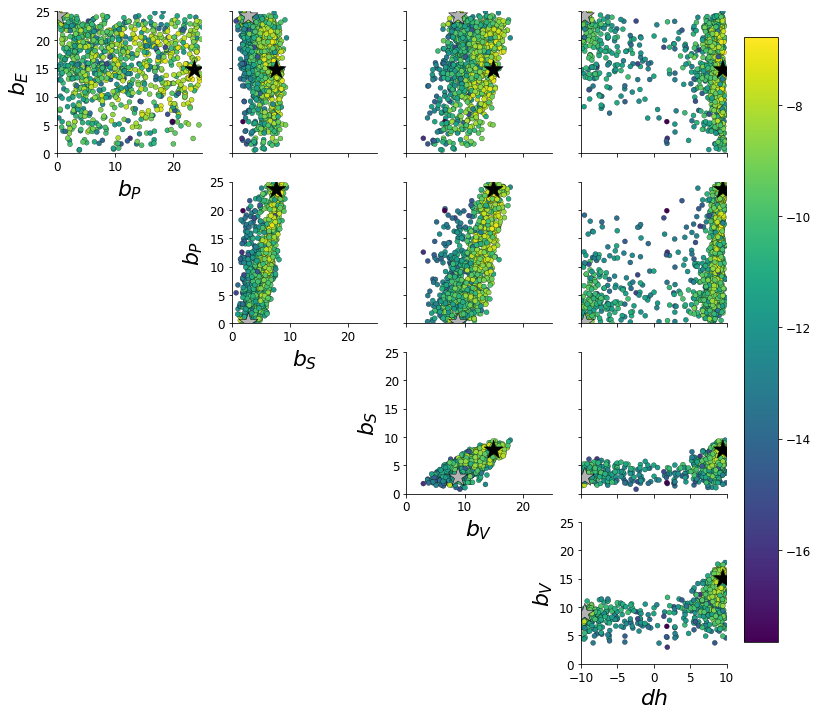

In [11]:
M = 1000
s = 25

z, log_q_z = dist.nf(M)
z = z.numpy()
log_q_z = log_q_z.numpy()

z1 = z[z[:,4] > 0., :]
log_q_z1 = log_q_z[z[:,4] > 0.]
z2 = z[z[:,4] < 0., :]
log_q_z2 = log_q_z[z[:,4] < 0.]
z_mode1 = z1[np.argmax(log_q_z1)][None,:]
z_mode2 = z2[np.argmax(log_q_z2)][None,:]
z_modes = np.concatenate((z_mode1, z_mode2), axis=0)
np.savez('SV_mode.npz', z_mode1=z_mode1, z_mode2=z_mode2)

alpha_c_star = 1.
c_star = [np.concatenate((np.array([0,0,0]), np.array([alpha_c_star]))),
             np.concatenate((.7*np.ones((3,)), np.array([alpha_c_star])))]


neurons = [alpha for alpha in neuron_inds.keys()]
labels = [r'$b_%s$' % alpha for alpha in neurons]
labels += [r'$dh$']
fig, axs, = pairplot(z, range(5), labels, s=s,
                     fontsize=22, lb=dist.nf.lb, ub=dist.nf.ub,
                     c=log_q_z, c_label='',
                     starred=z_modes, c_starred=c_star)
plt.savefig(figdir + 'SV_flip_z.png')

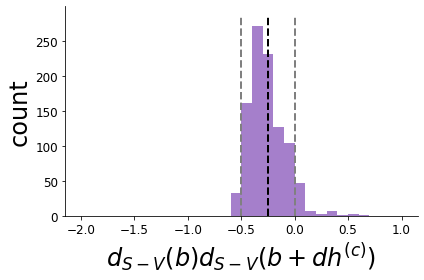

In [12]:
from epi.util import plot_T_x

T_x = model.eps(z).numpy()
xmins = [-2, -1.5]
xmaxs = [1, 1.5]
xlabels = [r"$d_{S-V}(b)d_{S-V}(b+dh^{(c)})$",
           r"$d_{S-V}(b) + d_{S-V}(b+dh^{(c)})$"]
for i in range(1):
    plot_T_x(None, T_x[:,i], xmin=xmins[i], xmax=xmaxs[i], 
             x_mean = mu[i], x_std = np.sqrt(mu[i+1]),
             xlabel=xlabels[i], fontsize=24)
    plt.tight_layout()
    plt.savefig(figdir + 'SVflip_Tx%d.png' % (i+1))

In [45]:
def SSSN_sim_traj(h, N=20):
    h = h[:,None,:,None]

    W = load_W()
    sigma_eps = 0.2*np.array([1., 0.5, 0.5, 0.5])
    tau = np.array([0.02, 0.01, 0.01, 0.01])
    tau_noise = np.array([0.05, 0.05, 0.05, 0.05])

    W = W[None,:,:,:]
    sigma_eps = sigma_eps[None,None,:,None]
    tau = tau[None,None,:,None]
    tau_noise = tau_noise[None,None,:,None]
   
    _v_shape = tf.ones((h.shape[0], N, 4, 1), dtype=tf.float32)
    v_init = _v_shape*V_INIT
    eps_init = 0.*_v_shape
    y_init = tf.concat((v_init, eps_init), axis=2)
    
    def f(y):
        v = y[:,:,:4,:]
        eps = y[:,:,4:,:]
        B = tf.random.normal(eps.shape, 0., np.sqrt(dt))
       
        dv = (-v + v_rest + h + eps + tf.matmul(W, f_r(v))) / tau
        deps = (-eps + (np.sqrt(2.*tau_noise)*sigma_eps*B/dt)) / tau_noise
        
        return tf.concat((dv, deps), axis=2)
        
    v_t = euler_sim_stoch_traj(f, y_init, dt, T)
    
    return v_t

def SSSN_stats(h, N=20):
    v_t = SSSN_sim_traj(h, N)[:,:,:4,:]
    r_t = v_t
    avg_r = tf.reduce_mean(r_t[:,:,:,(T//2):], axis=3)
    std_r = tf.math.reduce_std(r_t[:,:,:,(T//2):], axis=3)
    
    mean_avg_r = tf.reduce_mean(avg_r, axis=1)
    mean_std_r = tf.reduce_mean(std_r, axis=1)
    std_std_r = tf.math.reduce_std(std_r, axis=1)
    
    return tf.concat((mean_avg_r, mean_std_r, std_std_r), axis=1)

def plot_responses(z):
    h = z[:4]
    dh = z[4]
    gamma = np.concatenate((np.array([0., 1.]), np.linspace(0., 1., 101)), axis=0)
    dh_pattern = tf.constant(np.array([[1., 1., 0., 0.]], dtype=np.float32))
    _h = h + dh*gamma[:,None]*dh_pattern
    v_t = SSSN_sim_traj(_h).numpy()
    T_x = SSSN_stats(_h)
    
    neurons = ['E', 'P', 'S', 'V']
    plt.figure()
    for i in range(4):
        plt.errorbar(gamma[2:], T_x[2:,i], T_x[2:,i+4], c=colors[i])
    plt.legend(neurons)
    plt.ylabel('means')
    plt.show()
    
    plt.figure()
    for i in range(4):
        plt.errorbar(gamma[2:], T_x[2:,i+4], T_x[2:,i+8], c=colors[i])
    plt.ylabel('noise')
    plt.legend(neurons)
    plt.show()


    
    t = dt*np.arange(T+1)
    
    for gamma_ind in [0, 1]:
        plt.figure()
        for neuron in neurons:
            ind = neuron_inds[neuron]
            plt.plot(t, v_t[gamma_ind,0,ind,:], c=colors[ind], lw=3)
        plt.plot([t[0], t[-1]], [-70, -70], 'k--', lw=3)
        h_gamma = _h[gamma_ind]
        plt.title('h = [%.2f %.2f %.2f %.2f]mV' % tuple([h_gamma[j] for j in range(4)]))
        plt.xlabel('time')
        plt.ylabel(r'$v_\alpha(t)$')
        plt.legend(neurons, title=r'$\alpha$')
        plt.show()
    
       
    mean_v_t = np.mean(v_t, axis=1)
    mean_r_t = np.mean(f_r(v_t), axis=1)
    std_v_t = np.std(v_t, axis=1)
    std_r_t = np.std(f_r(v_t), axis=1)
    
    fig, axs = plt.subplots(1,3,figsize=(15,5))
    for neuron in neurons:
        ind = neuron_inds[neuron]
        axs[0].errorbar(gamma[2:], mean_v_t[2:,ind,-1], std_v_t[2:,ind,-1], c=colors[ind], lw=3)
        axs[1].errorbar(gamma[2:], mean_r_t[2:,ind,-1], std_r_t[2:,ind,-1], c=colors[ind], lw=3)
        axs[2].plot(gamma[2:], std_r_t[2:,ind,-1], c=colors[ind], lw=3)
    axs[0].set_ylabel('v')
    axs[1].set_ylabel('r')
    axs[1].plot([gamma[2], gamma[-1]], [2., 2.], 'k--')
    axs[1].plot([.5,.5], [0, 50], 'k--')
    plt.show()
    
    return v_t[2:]

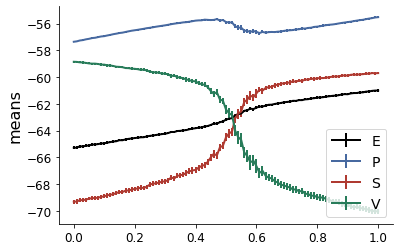

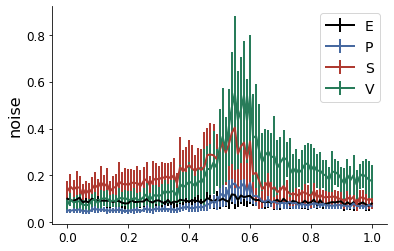

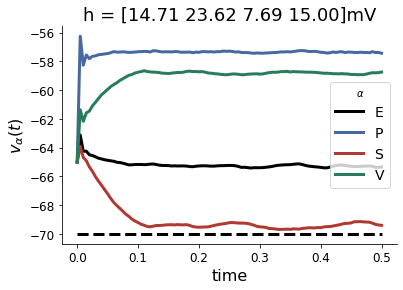

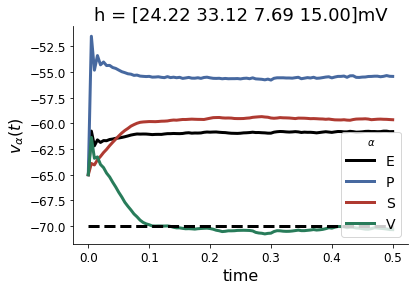

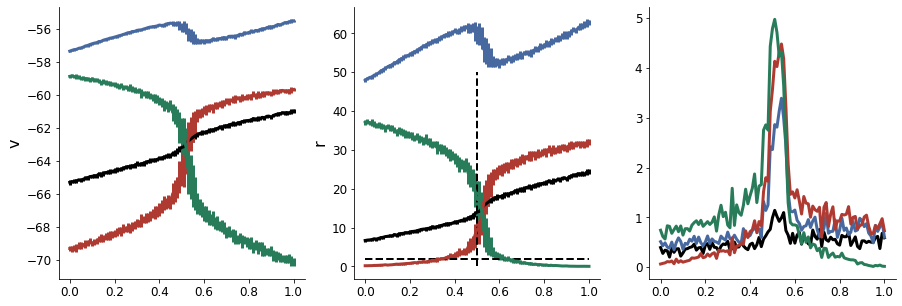

In [46]:
v_t = plot_responses(z_mode1[0])

In [28]:
print(v_t.shape)
r_t = f_r(v_t).numpy()
mean_r_t = np.mean(r_t, axis=1)
var_r_t = np.var(r_t, axis=1)
print(mean_r_t[0,:4,-1])
print(var_r_t[0,:4,-1])
print(mean_r_t[-1,:4,-1])
print(var_r_t[-1,:4,-1])

(101, 20, 8, 101)
[ 6.6826468  47.944347    0.14583257 37.13505   ]
[0.1104025  0.13825181 0.00836299 0.4690383 ]
[2.4190069e+01 6.2782684e+01 3.1848785e+01 3.4879260e-03]
[2.5415048e-01 5.7959133e-01 7.8977907e-01 6.8490874e-05]


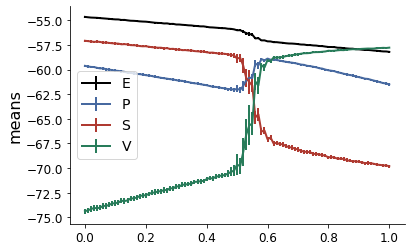

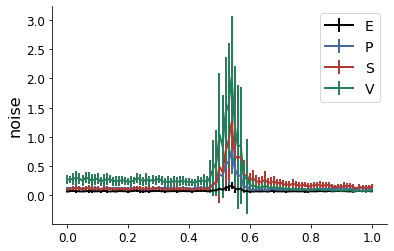

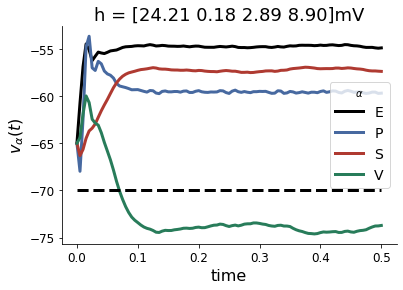

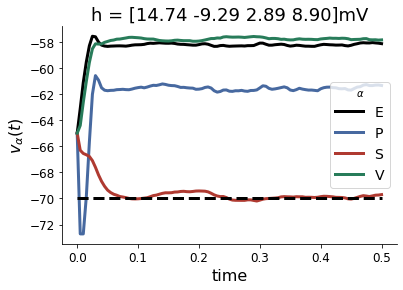

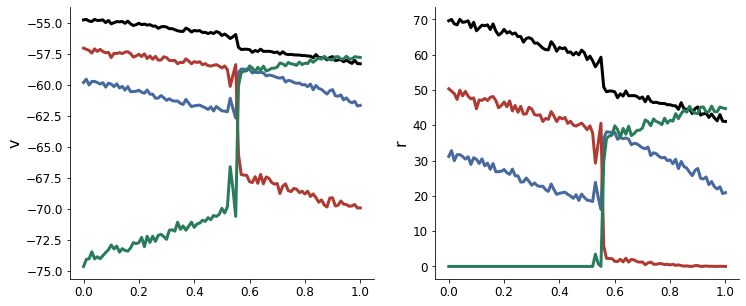

In [55]:
plot_responses(z_mode2[0])

In [30]:
h = z[:,:4]
dh = z[:,4:6]
r_t1s = []
r_t2s = []
r_t1s = SSN_sim(h, 0.*dh)
r_t2s = SSN_sim(h, dh)
   
SV_diff1 = (r_t1s[:,2,-1] - r_t1s[:,3,-1]).numpy()
SV_diff2 = (r_t2s[:,2,-1] - r_t2s[:,3,-1]).numpy()
nbins = 30

label1 = r'$dh^{(c)}_E > 0$'
label2 = r'$dh^{(c)}_E < 0$'

fontsize = 32

fig, axs = plt.subplots(1,2, figsize=(10,6))
axs[0].hist(SV_diff1[dh[:,0] > 0.], nbins, color='k', alpha=0.5, label=label1)
axs[0].hist(SV_diff1[dh[:,0] < 0.], nbins, color=.7*np.ones((3,)), alpha=0.5, label=label2)
axs[0].set_xlabel(r'$d_{S-V}(b)$', fontsize=fontsize)
axs[0].set_ylabel("count", fontsize=fontsize)
axs[0].legend(fontsize=fontsize)
axs[0].set_ylim([0,35])
axs[1].hist(SV_diff2[dh[:,0] > 0.], nbins, color='k', alpha=0.5, label=label1)
axs[1].hist(SV_diff2[dh[:,0] < 0.], nbins, color=.7*np.ones((3,)), alpha=0.5, label=label2)
axs[1].set_xlabel(r'$d_{S-V}(b + dh^{(c)})$', fontsize=fontsize)
axs[1].set_ylim([0,35])
plt.tight_layout()
plt.savefig(figdir + "SVflip_sim_diffs.png")
plt.show()

NameError: name 'SSN_sim' is not defined

In [ ]:
fac = 10
npzfile = np.load("data/V1_Zs.npz")
_W = npzfile["Z_allen_square"][None, :, :]
_W[:, :, 1:] = -_W[:, :, 1:]
W_E = fac*_W[0,0,:]

def V1_sim(h, dh):
    h = h[:, :, None]
    dh = tf.concat((dh, tf.zeros_like(dh, dtype=tf.float32)), axis=1)[:, :, None]

    n = 2.
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones_like(h, dtype=tf.float32)
    x_init = _x_shape*X_INIT

    npzfile = np.load("data/V1_Zs.npz")
    _W = npzfile["Z_allen_square"][None, :, :]
    _W[:, :, 1:] = -_W[:, :, 1:]
    W = fac*tf.constant(_W, dtype=tf.float32)

    def f(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

    r_t = euler_sim_traj(f, x_init, dt, T)
    return r_t

def ISN_coeff(z):
    h = z[:,:4]
    dh = z[:,4:]

    r_ts = V1_sim(h, 0.*dh)
    r_ss = r_ts[:,:,-1].numpy()
    h_E = h[:,0]
    u_E = np.dot(W_E, r_ss.T) + h_E
    u_E[u_E < 0.] = 0.
    ISN_coeff1 = 1.-2*(u_E)*W_E[0]
    
    r_ts = V1_sim(h, dh)
    r_ss = r_ts[:,:,-1].numpy()
    h_E = h[:,0] + dh[:,0]
    u_E = np.dot(W_E, r_ss.T) + h_E
    u_E[u_E < 0.] = 0.
    ISN_coeff2 = 1.-2*(u_E)*W_E[0]
    
    return ISN_coeff1, ISN_coeff2

ISN_coeff1, ISN_coeff2 = ISN_coeff(z)

In [ ]:
plt.figure()
plt.hist(ISN_coeff1)
plt.show()

plt.figure()
plt.hist(ISN_coeff2)
plt.show()
